In [115]:
import joblib
import cv2
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import skimage.feature as feature

import torchvision.transforms as transforms
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS

from sklearn.model_selection import train_test_split

from pytorchyolo.models import load_model
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

from minepsilon import yf_det_fn as yf_detect_faces
from minepsilon import mp_det_fn as mp_detect_faces
from minepsilon import yn_det_fn as yn_detect_faces

from generate_perturbation import pipeline
from extract_image_mask import create_mask

from custom_mlp import CustomMLP
from custom_mlp import custom_scorer

In [116]:
FILENAME = 'ths-st3 compiled dataset.csv'
df = pd.read_csv(FILENAME)

In [117]:
yolo_device, yolo_model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

In [118]:
# def generate_fgsm_features(dataframe):
#     for i in range(18):
#         df['hsv_h_' + str(i)] =  df['H_HSV_BIN_bbox_' + str(2 * i)] + df['H_HSV_BIN_bbox_' + str(2 * i + 1)]
#     df['area'] = df['w'] * df['h']
#     return df

In [119]:
# df = generate_fgsm_features(df)
# df

In [120]:
import os
filenames = []
for path in df['path']:
    filenames.append(os.path.basename(path))
df['filename'] = filenames
df

,path,source_w,source_h,face_index,obj_score,class_score,x1,y1,x2,y2,...,e_bbox_mp,e_bbox_yf,e_lbbox_yn,e_lbbox_mp,e_lbbox_yf,x,y,w,h,filename
0,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,683,1024,75,0.531384,0.999730,339,207,346,215,...,0.000,0.090,0.000,0.000,0.075,0.824519,0.508413,0.019231,0.021635,0_Parade_marchingband_1_141.jpg
1,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,899,1024,41,0.963016,0.999830,200,95,205,102,...,0.000,0.600,0.000,0.000,0.285,0.487981,0.237981,0.014423,0.019231,0_Parade_marchingband_1_164.jpg
2,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,23,0.953876,0.999671,116,214,120,220,...,0.000,0.435,0.000,0.000,0.285,0.284856,0.522837,0.012019,0.016827,0_Parade_marchingband_1_220.jpg
3,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,21,0.993056,0.999989,149,182,158,191,...,0.000,0.255,0.080,0.000,0.195,0.370192,0.449519,0.024038,0.024038,0_Parade_marchingband_1_258.jpg
4,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,1,0.930012,0.999633,380,252,383,257,...,0.000,0.245,0.000,0.000,0.080,0.918269,0.612981,0.009615,0.014423,0_Parade_marchingband_1_363.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24813,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,233,191,0,0.999565,0.999897,131,101,300,376,...,0.200,0.205,0.150,0.235,0.165,0.519231,0.574519,0.408654,0.663462,009970.jpg
24814,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,500,366,0,0.999923,0.999958,139,120,291,340,...,0.180,0.400,0.140,0.200,0.185,0.518029,0.554087,0.367788,0.531250,009974.jpg
24815,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,337,286,0,0.999941,0.999918,122,65,301,309,...,0.145,0.240,0.115,0.130,0.160,0.509615,0.450721,0.432692,0.588942,009992.jpg
24816,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,235,215,0,0.999938,0.999973,122,97,272,307,...,0.225,0.200,0.150,0.225,0.155,0.474760,0.486779,0.362981,0.507212,009997.jpg


In [121]:
def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = feature.local_binary_pattern(gray, 24, 8, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 24+3), range=(0, 24 + 2))
    
    # Normalize the histogram
    hist = hist.astype('float') 
    hist /= (hist.sum() + 1e-7)
    return hist

In [122]:
def extract_hsv(image, h_bins=18, s_bins=26, v_bins=26):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    h, s, v = cv2.split(hsv)
    
    h_hist = cv2.calcHist([h], [0], None, [h_bins], [0, 180])
    h_hist = h_hist.ravel()
    h_hist = h_hist.astype('float')
    h_hist /= h_hist.sum()
    
    s_hist = cv2.calcHist([s], [0], None, [s_bins], [0, 256])
    s_hist = s_hist.ravel()
    s_hist = s_hist.astype('float')
    s_hist /= s_hist.sum()
    
    v_hist = cv2.calcHist([v], [0], None, [v_bins], [0, 256])
    v_hist = v_hist.ravel()
    v_hist = v_hist.astype('float')
    v_hist /= v_hist.sum()
    
    return h_hist, s_hist, v_hist

In [123]:
def extract_sobel(path, face_index, image, version):
    # Uses the Sobel Filter to extract the gradients of an image
    
    # compute the 1st order Sobel derivative in X-direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

    # compute the 1st order Sobel derivative in Y-direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # combine sobelx and sobely to form sobel
    sobel = sobelx + sobely
    
    sobelx_hist = cv2.calcHist([np.float32(sobelx)], [0], None, [26], [0, 256])
    sobelx_hist = sobelx_hist.ravel()
    sobelx_hist = sobelx_hist.astype('float')
    sobelx_hist /= sobelx_hist.sum()
    
    sobely_hist = cv2.calcHist([np.float32(sobely)], [0], None, [26], [0, 256])
    sobely_hist = sobely_hist.ravel()
    sobely_hist = sobely_hist.astype('float')
    sobely_hist /= sobely_hist.sum()
    
    sobel_hist = cv2.calcHist([np.float32(sobel)], [0], None, [26], [0, 256])
    sobel_hist = sobel_hist.ravel()
    sobel_hist = sobel_hist.astype('float')
    sobel_hist /= sobel_hist.sum()
    
    return sobelx_hist, sobely_hist, sobel_hist

In [124]:
def generate_gaussian(image, model, feature_image, x, y, w, h, source_wh):
    source_x, source_y, source_w, source_h = int(x / 416 * source_wh), int(y / 416 * source_wh), int(w / 416 * source_wh), int(h / 416 * source_wh)
    x1, y1, x2, y2 = int(source_x - source_w/2), int(source_y - source_h/2), int(source_x + source_w/2), int(source_y + source_h/2)
    
    bbox_region = feature_image[max(0, y1) : min(source_wh-1, y2), max(0, x1) : min(source_wh-1, x2), :]
    
    h_hist, s_hist, v_hist = extract_hsv(bbox_region)
    lbp_hist = extract_lbp(bbox_region)
    features = [(source_w) / 416, (source_h) / 416] + h_hist.tolist() + s_hist.tolist() + v_hist.tolist() + lbp_hist.tolist()             
    
    #create the gaussian noise
    np.random.seed(0)
    sigma = model.predict([features])
    
    if sigma < 0:
        warnings.warn("Predicted Sigma: " + str(sigma))
        sigma = 0
    
    x1, y1, x2, y2 = max(0, int(x - w/2)), max(0, int(y - h/2)), min(416, int(x + w/2)), min(416, int(y + h/2))
    gaussian = np.random.normal(0, sigma, (y2 - y1, x2 - x1, 3)) 
    
    noisy_img = image.astype('float64')
    # add gaussian noise to the img
    noisy_img[y1:y2, x1:x2, :] = noisy_img[y1:y2, x1:x2, :] + gaussian / 255
    
    # remove values that are <-1 and >255
    noisy_img = np.where(noisy_img < 0, 0, noisy_img)
    noisy_img = np.where(noisy_img > 1, 1, noisy_img)
    
    #convert img back to uint
#     noisy_img = (noisy_img * 255).astype('uint8')
    
    return noisy_img

In [125]:
def generate_fgsm(img_path, model):
    create_mask(img_path)
#     def pipeline(path, eps_model, color_space, extract_region, perturb_region, given_index=None, model=model, device=device):
    image = pipeline(img_path, fgsm_model, 'HSV', 'bbox', 0)
    image = np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))
    return image

In [126]:
def generate_naive(image, e, gradient, x, y, w, h):
    x1, y1, x2, y2 = max(0, int(x - w/2)), max(0, int(y - h/2)), min(416, int(x + w/2)), min(416, int(y + h/2))
    image[y1:y2, x1:x2, :] = image[y1:y2, x1:x2, :] + e * gradient[y1:y2, x1:x2, :]
    image = np.clip(image, 0, 1)
    return image

In [127]:
def image_to_tensor(image):
    return transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((image, np.zeros((1, 5))))[0].unsqueeze(0)

def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))

In [128]:
def pad_square_image(image):
    height, width, _ = image.shape

    # Find the longer side and calculate the padding size
    max_dim = max(height, width)
    pad_height = (max_dim - height) // 2
    pad_width = (max_dim - width) // 2

    # Add padding to make the image square
    padded_image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_CONSTANT)

    return padded_image

In [129]:
def get_crop_padding_coordinates(image):
    # Find the non-zero pixels in the image
    non_zero_pixels = cv2.findNonZero(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(non_zero_pixels)
    
    return x, y, w, h

def crop_padding(image, x, y, w, h):
    # Crop the image using the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

In [130]:
# import joblib 
gaussian_model = joblib.load("model_dumps/gaussian_mpr.pkl")
fgsm_model = joblib.load("model_dumps/mpr_tunedfs_HSV_bbox_e_bbox_yf.pkl")

In [131]:
path = r"image.jpg"
labels = ["A", "B", "C", "D"]
order = ['image', 'gaussian', 'fgsm_naive', 'fgsm_model']

In [132]:
def set_gradient_mode(gradient_mode):
    yolo_model.gradient_mode = gradient_mode
    for yolo_layer in yolo_model.yolo_layers:
        yolo_layer.gradient_mode = gradient_mode

image


2023-06-25 02:39:03,115 - part_label_dataset - INFO - reading the image files...
2023-06-25 02:39:03,116 - part_label_dataset - INFO - finished initializing the dataloader 1 files.
viz: 0it [00:03, ?it/s]

IMAGE FILENAME IS: image_0_image_final.png


mask_image_0_image_final.png
Face 0
Predicted Epsilon [0.2342165]


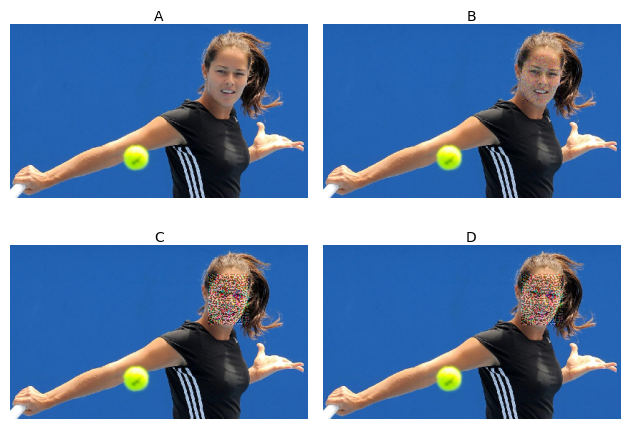

In [133]:

create_mask(path)

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# pad_image = resize_image(image, (416, 416), 0)
tensor_image = image_to_tensor(image)
result_image = tensor_to_image(tensor_image)
source_h, source_w, _ = image.shape
crop_x, crop_y, crop_w, crop_h = get_crop_padding_coordinates(result_image)

yolo_model.eval()
set_gradient_mode(False)
with torch.no_grad():
    nms, nms_output = non_max_suppression(yolo_model(tensor_image), 0.5, 0.5) #conf_thres and iou_thres = 0.5

tensor_image = tensor_image.to(yolo_device)
tensor_image.requires_grad = True
set_gradient_mode(True)

output = yolo_model(tensor_image)

face_list = nms_output[0] if type(nms_output[0]) is not int else []
# print(face_list)
# series = df[df['filename'] == path]

fig, axs = plt.subplots(2, 2)
# Iterate over the image paths and display images in subplots
for i, image_type in enumerate(order):
    row = i // 2
    col = i % 2
    result_image = tensor_to_image(tensor_image)

    for face_index, face_bbox in enumerate(face_list):
        x, y, w, h = face_bbox[0], face_bbox[1], face_bbox[2], face_bbox[3]

        if (image_type == 'image'):
            result_image = result_image
            break
        elif (image_type == 'fgsm_model'):
            result_image = generate_fgsm(path, fgsm_model)
        elif (image_type == 'fgsm_naive'):
            normal_x, normal_y, normal_w, normal_h = x / 415, y / 415, w / 415, h / 415

            target = torch.tensor([[0.0, 0, normal_x, normal_y, normal_w, normal_h]])
            target = target.to(yolo_device)

            loss, loss_components = compute_loss(output, target, yolo_model)

            yolo_model.zero_grad()
            tensor_image.grad = None

            loss.backward(retain_graph=True)

            result_image = generate_naive(path, result_image, 0.26, tensor_to_image(tensor_image.grad.data.sign()), x, y, w, h, face_index)   
#                 result_image = image_to_tensor(result_image)
        elif (image_type == 'gaussian'):
            max_hw = max(source_h, source_w)
            result_image = generate_gaussian(result_image, pad_square_image(image), x, y, w, h, max_hw)
        else:
            raise Exception("Invalid Order")

    # Display the image in the corresponding subplot
    result_image = crop_padding(result_image, crop_x, crop_y, crop_w, crop_h)
    axs[row, col].imshow(result_image)
    axs[row, col].axis("off")  # Optionally turn off axis labels

    axs[row, col].set_title(labels[i], fontsize=10, pad=0)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

In [134]:
size_order = ['L', 'S', 'M', 'S', 'L', 'M', 'M', 'S', 'L']